# cMLP Lagged VAR Demo

- In this notebook, we train a cMLP model on linear VAR data with lagged interactions.
- After examining the Granger causality discovery, we train a debiased model using only the discovered interactions.

In [ ]:
# import library
import os
import torch
import csv
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import preprocessing
from models.cmlp import cMLP, train_model_ista

In [ ]:
#モーションキャプチャデータの読み込み
#読み込んだデータを入れる箱(ここはとりあえず手動で)
data=torch.zeros([10,625,27]) #[ファイル数, データ長さ, 変数の数]

#ファイル名の取得
dir_path = "./input_datasets/sub01vs01/"
file_list = glob.glob(os.path.join(dir_path, "*.csv"))
count=0;
for file_path in file_list:
    file = pd.read_csv(file_path, header=None)
    for i in range(file.shape[0]):
      for j in range(file.shape[1]):
        data[count][i][j]=np.float_(file[j][i])
    count=count+1;

print(data.size())

#ダウンサンプリング(元は250hzから50hzへ)
dawn_size=5;

if data.size()[1]%dawn_size>0:
  add=1
else:
  add=0

data_d=torch.zeros([data.size()[0],data.size()[1]//dawn_size+add,data.size()[2]])

for i in range(data_d.size()[0]): #10個分のデータを処理
  count=0
  for j in range(len(data[0])):
    if j%dawn_size==0:
       for k in range(data_d.size()[2]):
         data_d[i][count][k]=data[i][j][k]
       count=count+1

print(data_d.size())

torch.Size([10, 625, 27])
torch.Size([10, 125, 27])


# Still need to tune $\lambda$ and perhaps lr

(10, 125, 27)
----------Iter = 100----------
Loss = 0.339823
Variable usage = 100.00%
----------Iter = 200----------
Loss = 0.260927
Variable usage = 100.00%
----------Iter = 300----------
Loss = 0.183257
Variable usage = 100.00%
----------Iter = 400----------
Loss = 0.107358
Variable usage = 100.00%
----------Iter = 500----------
Loss = 0.039370
Variable usage = 100.00%
----------Iter = 600----------
Loss = 0.018137
Variable usage = 72.70%
----------Iter = 700----------
Loss = 0.016754
Variable usage = 65.71%
----------Iter = 800----------
Loss = 0.016164
Variable usage = 58.57%
----------Iter = 900----------
Loss = 0.015971
Variable usage = 54.73%
----------Iter = 1000----------
Loss = 0.015398
Variable usage = 50.07%
----------Iter = 1100----------
Loss = 0.015179
Variable usage = 47.87%
----------Iter = 1200----------
Loss = 0.015025
Variable usage = 46.64%
----------Iter = 1300----------
Loss = 0.014900
Variable usage = 44.17%
----------Iter = 1400----------
Loss = 0.014777
Variab

<Axes: >

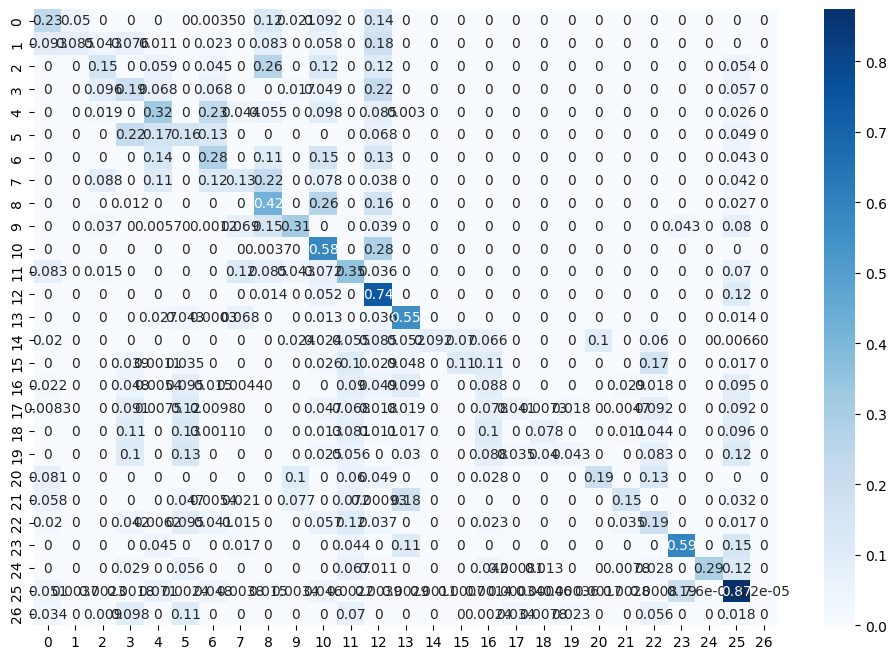

In [ ]:
# For GPU acceleration
device = torch.device('cuda')

# データを結合してGPUへ送る(10,131,27)
X_motion = data_d
X_motion = X_motion.to(device)

X_motion_np = X_motion.to('cpu').detach().numpy().copy()
X_motion_np=np.squeeze(X_motion_np)

print(X_motion_np.shape)

# Set up model
#hidden=100
cmlp = cMLP(X_motion.shape[-1], lag=50, hidden=[32]).cuda(device=device)
#clstm = cLSTM(X_motion.shape[-1], hidden=128).cuda(device=device)

# Train with ISTA
#50000
#lam,0.002: Hペナルティとかの比率(weight)
#lam_ridge: L2正則化のパラメータ
#lr: learninig late

train_loss_list = train_model_ista(cmlp, X_motion, lr=5e-2, max_iter=2000, lam=0.003, lam_ridge=1e-2, penalty='GSGL',
                                   lookback=10, check_every=100, verbose=1)

# train_loss_list =train_model_gista(cmlp, X_motion, lam=0.003, lam_ridge=1e-2, lr=5e-2, penalty='GSGL', max_iter=1500,
#                       check_every=50, r=0.8, lr_min=1e-8, sigma=0.5,
#                       monotone=False, m=10, lr_decay=0.5,
#                       begin_line_search=True, switch_tol=1e-3, verbose=1)

#GC: (p x p) or (p x p x lag) matrix. In first case, entry (i, j)
#            indicates whether variable j is Granger causal of variable i. In
#            second case, entry (i, j, k) indicates whether it's Granger causal
#            at lag k.

GC_est = cmlp.GC(threshold=False).cpu().data.numpy()
#print(GC_est)

plt.figure(figsize=(12, 8))
sns.heatmap(GC_est,cmap='Blues',annot=True)

In [ ]:
GC_est_lag = cmlp.GC(ignore_lag=False, threshold=False).cpu().data.numpy()
for i in range(50):
  print(np.sum(GC_est_lag[13:26,0:12,i]))#ピッチャーからバッター
  #print(np.sum(GC_est_lag[0:12,0:12,i]))#ピッチャー内
  #print(np.sum(GC_est_lag[13:26,13:26,i]))#バッター内

0.07377723
0.081881315
0.049951293
0.020388987
0.0054539084
0.0068336846
0.008884009
0.008494826
0.006037227
0.0049367035
0.005371818
0.00563874
0.0065718624
0.019143868
0.028030772
0.041172497
0.053356368
0.08100418
0.1081571
0.17322862
0.28006464
0.358931
0.43065605
0.5568943
0.6460532
0.74321973
0.79880595
0.7944391
0.7062395
0.52896506
0.30789262
0.18534145
0.115534514
0.0910177
0.10946028
0.117189296
0.12375142
0.16321597
0.20761846
0.20666534
0.16977948
0.11910189
0.070609935
0.060724903
0.060863353
0.053678747
0.03678065
0.021591203
0.024803907
0.025467705


In [ ]:
#結果の出力
with open("GC_pair01.csv", "w", newline="") as f:
  writer = csv.writer(f)
  for row in GC_est:
    writer.writerow(row)

#delay
for i in range(50):
  file_name=f'delay{50-i:02d}.csv';
  #print(file_name)
  with open(file_name, "w", newline="") as f:
    writer = csv.writer(f)
    for row in GC_est_lag[:,:,i]:
      writer.writerow(row)